In [1]:
! pip install opendatasets


In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images


In [1]:
# Cell 1: Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Cell 2: Define image preprocessing functions
def load_image(image_path):
    """Step 1: Load image - Read the image file"""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    return img

# Cell 5: More preprocessing functions
def resize_image(image):
    """Step 2: Resize - Convert to 224x224 pixels"""
    return cv2.resize(image, (224, 224))

def normalize_image(image):
    """Step 3: Normalize - Scale pixel values to 0-1"""
    return image / 255.0

def convert_to_tensor(image):
    """Step 4: Convert to Tensor - Prepare image for training"""
    return tf.convert_to_tensor(image, dtype=tf.float32)

# Cell 6: Full preprocessing pipeline
# Full preprocessing pipeline for a single image
def preprocess_image(image_path):
    img = load_image(image_path)  # Step 1
    img = resize_image(img)       # Step 2
    img = normalize_image(img)    # Step 3
    img_tensor = convert_to_tensor(img)  # Step 4
    return img_tensor

In [3]:
# Define directory paths to match your structure
data_root = r"C:\Users\tejag\OneDrive\Desktop\AIML project\AML-Project\deepfake-and-real-images"  # Adjust this if needed
train_dir = os.path.join(data_root, "Dataset/Train")
val_dir = os.path.join(data_root, "Dataset/Validation")
test_dir = os.path.join(data_root, "Dataset/Test")

# Verify directories exist
print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Validation directory exists: {os.path.exists(val_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")



Train directory exists: True
Validation directory exists: True
Test directory exists: True


In [4]:
# Create data generators incorporating the preprocessing steps
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Step 3: Normalize
    rotation_range=20,  # Step 5: Data Augmentation
    width_shift_range=0.2,  # Step 5: Data Augmentation
    height_shift_range=0.2,  # Step 5: Data Augmentation
    shear_range=0.2,  # Step 5: Data Augmentation
    zoom_range=0.2,  # Step 5: Data Augmentation
    horizontal_flip=True  # Step 5: Data Augmentation
)

# Only normalize for validation and test (no augmentation needed)
val_datagen = ImageDataGenerator(rescale=1./255)  # Step 3: Normalize
test_datagen = ImageDataGenerator(rescale=1./255)  # Step 3: Normalize
batch_size = 32

In [25]:
# Create generators
batch_size = 32

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Step 2: Resize
    batch_size=batch_size,
    class_mode='binary',
    classes=['Real', 'Fake']  # Changed to match your capitalization
)

# Modify your training data generator to use a subset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.8  # This will use only 20% of your data
)

# Then in your test_generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    classes=['Real', 'Fake'],
    subset='training'  # This will use the training subset
)

Found 39428 images belonging to 2 classes.
Found 2182 images belonging to 2 classes.


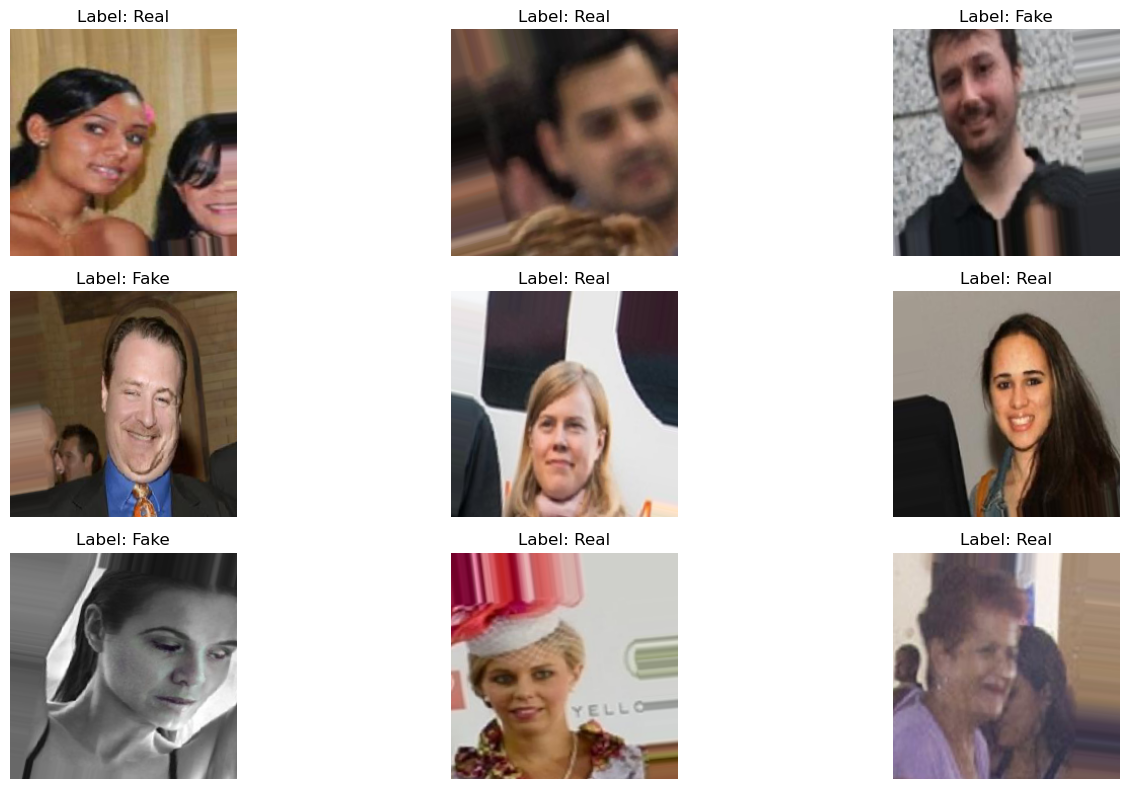

In [19]:
plt.figure(figsize=(15, 8))
sample_batch = next(train_generator)
for i in range(min(9, batch_size)):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_batch[0][i])
    plt.title(f"Label: {'Real' if sample_batch[1][i] == 0 else 'Fake'}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [7]:
def create_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification: real vs fake
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [8]:
# Create the model
model = create_model()
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint(
        'deepfake_detector_model.h5', 
        save_best_only=True, 
        monitor='val_accuracy'
    )
]

In [10]:
# Cell 13: Set epochs
epochs = 10

In [12]:
# Simply limit how many batches you process per epoch
history = model.fit(
    train_generator,
    steps_per_epoch=300,  # Only process 200 batches regardless of dataset size
    validation_data=validation_generator,
    validation_steps=50,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6906 - loss: 0.5988

300/300 ━━━━━━━━━━━━━━━━━━━━ 470s 2s/step - accuracy: 0.6906 - loss: 0.5987 - val_accuracy: 0.7319 - val_loss: 0.5214 - learning_rate: 0.0010
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7466 - loss: 0.5131

300/300 ━━━━━━━━━━━━━━━━━━━━ 444s 1s/step - accuracy: 0.7466 - loss: 0.5131 - val_accuracy: 0.7331 - val_loss: 0.5228 - learning_rate: 0.0010
Epoch 3/10
276/300 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7538 - loss: 0.4937

c:\Users\tejag\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.7540 - loss: 0.4934 - val_accuracy: 0.7544 - val_loss: 0.4922 - learning_rate: 0.0010
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7555 - loss: 0.4866

300/300 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.7555 - loss: 0.4866 - val_accuracy: 0.7725 - val_loss: 0.4667 - learning_rate: 0.0010
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7682 - loss: 0.4708

300/300 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - accuracy: 0.7682 - loss: 0.4708 - val_accuracy: 0.7788 - val_loss: 0.4543 - learning_rate: 0.0010
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.7635 - loss: 0.4819 - val_accuracy: 0.7494 - val_loss: 0.4994 - learning_rate: 0.0010
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7733 - loss: 0.4629

300/300 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.7732 - loss: 0.4629 - val_accuracy: 0.7900 - val_loss: 0.4339 - learning_rate: 0.0010
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7710 - loss: 0.4710

300/300 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.7710 - loss: 0.4710 - val_accuracy: 0.8231 - val_loss: 0.4055 - learning_rate: 0.0010
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.7685 - loss: 0.4700 - val_accuracy: 0.7713 - val_loss: 0.4562 - learning_rate: 0.0010
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.7684 - loss: 0.4668 - val_accuracy: 0.7962 - val_loss: 0.4297 - learning_rate: 0.0010


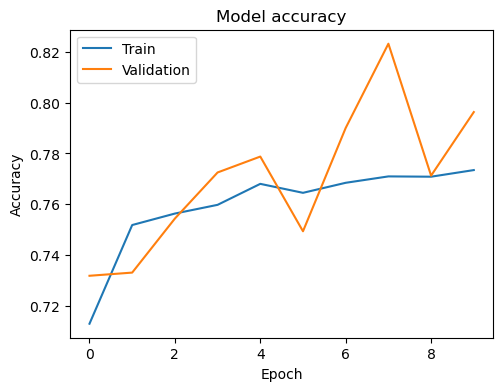

In [13]:
# Cell 15: Plot training accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

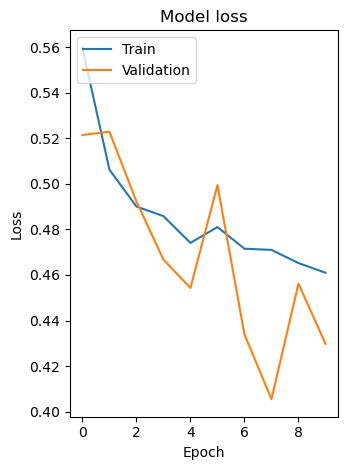

In [14]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [20]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

c:\Users\tejag\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


876/876 ━━━━━━━━━━━━━━━━━━━━ 2301s 3s/step - accuracy: 0.7698 - loss: 0.4622
Test Accuracy: 0.7706
Test Loss: 0.4606


In [21]:
# Function to make predictions on new images following the preprocessing steps
def predict_image(image_path, model):
    img = load_image(image_path)  # Step 1: Load image
    img = resize_image(img)       # Step 2: Resize
    img = normalize_image(img)    # Step 3: Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension for prediction
    # Step 4: Convert to tensor happens implicitly when passing to model.predict
    
    prediction = model.predict(img)[0][0]
    label = "Real" if prediction < 0.5 else "Fake"  # Adjust based on your class mapping
    confidence = 1 - prediction if prediction < 0.5 else prediction
    
    return label, confidence

In [22]:
# Function to visualize predictions on multiple test images
def visualize_predictions(model, test_generator, num_images=10):
    # Get a batch of test images
    test_batch = next(test_generator)
    images = test_batch[0][:num_images]
    true_labels = test_batch[1][:num_images]
    
    # Make predictions
    predictions = model.predict(images)
    pred_labels = (predictions > 0.5).flatten()
    
    # Display images with predictions
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        
        true_label = "Fake" if true_labels[i] == 1 else "Real"
        pred_label = "Fake" if pred_labels[i] == 1 else "Real"
        
        color = "green" if true_labels[i] == pred_labels[i] else "red"
        
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


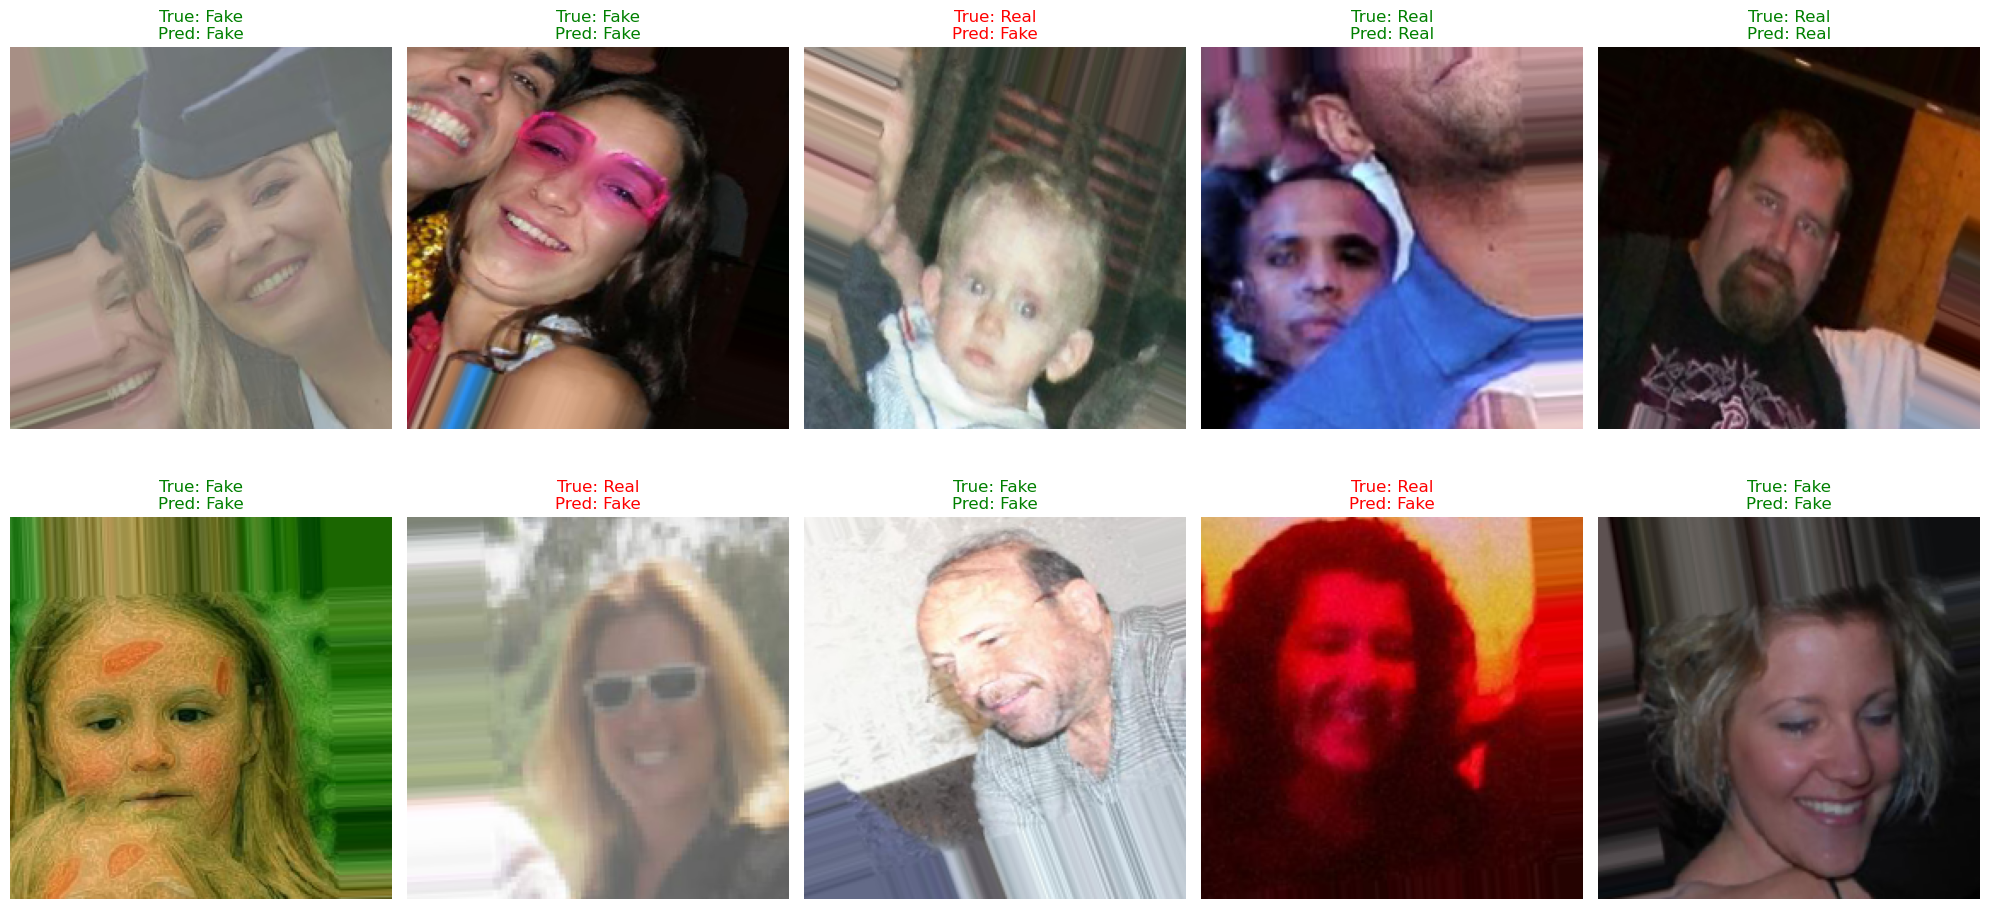

In [26]:
# Visualize some predictions
visualize_predictions(model, test_generator)

In [24]:
# Calculate confusion matrix
test_generator.reset()
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).flatten().astype(int)

876/876 ━━━━━━━━━━━━━━━━━━━━ 1088s 1s/step


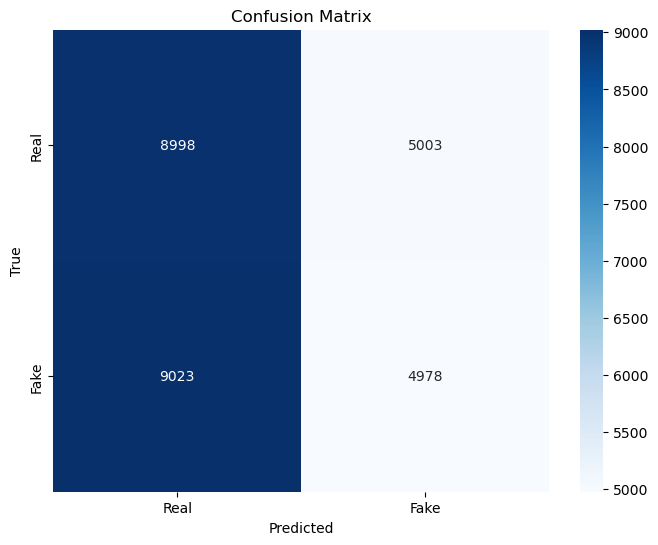

In [32]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [33]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

# Cell 24: Save the model
# Save the model for future use
model.save('deepfake_detector_final.h5')
print("Model saved successfully!")

Classification Report:
              precision    recall  f1-score   support

        Real       0.50      0.64      0.56     14001
        Fake       0.50      0.36      0.42     14001

    accuracy                           0.50     28002
   macro avg       0.50      0.50      0.49     28002
weighted avg       0.50      0.50      0.49     28002

Model saved successfully!


In [ ]:
#code is done